In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import pandas
import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
from src.model_s import SSD300, MultiBoxLoss
from src.datasets_s import PascalVOCDataset
from src.utils_s import *
from src.datasets import MILDataset

from src.eval import *
from src.utils import *

In [4]:
n_classes = 3  # number of different types of objects
BATCH_SIZE = 2
num_workers = 2

# Learning parameters
checkpoint = None  # path to model checkpoint, None if none
batch_size = BATCH_SIZE  # batch size
iterations = 40000  # number of iterations to train
print_freq = 50  # print training status every __ batches
lr = 1e-3  # learning rate
decay_lr_at = [8000, 10000]  # decay learning rate after these many iterations
decay_lr_to = 0.1  # decay learning rate to this fraction of the existing learning rate
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay

cudnn.benchmark = True

In [5]:
train_dataset = MILDataset('../dataset','train')

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


In [6]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10,
                                           collate_fn=collate_fn,
                                          num_workers=num_workers)

In [8]:
model = SSD300(n_classes=n_classes)


Loaded base model.



In [9]:
device = 'cuda'

In [10]:
model = model.to(device)

In [11]:
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)

/opt/anaconda3/envs/ane_env/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [12]:
biases = list()
not_biases = list()
for param_name, param in model.named_parameters():
    if param.requires_grad:
        if param_name.endswith('.bias'):
            biases.append(param)
        else:
            not_biases.append(param)

In [13]:
optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
                                lr=lr, momentum=momentum, weight_decay=weight_decay)

In [14]:
model.train()  # training mode enables dropout

batch_time = AverageMeter()  # forward prop. + back prop. time
data_time = AverageMeter()  # data loading time
losses = AverageMeter()  # loss

# train

In [15]:
epochs = iterations // (len(train_dataset) // 10)
decay_lr_at = [it // (len(train_dataset) // 10) for it in decay_lr_at]
epochs,decay_lr_at

(470, [94, 117])

In [17]:
for epoch in range(1, epochs):
    if epoch in decay_lr_at:
        adjust_learning_rate(optimizer, decay_lr_to)
        
    for i, (images, boxes, labels) in enumerate(train_loader):

        images = torch.stack(images).to(device)

        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]


        predicted_locs, predicted_scores = model(images.float())

        loss = criterion(predicted_locs, predicted_scores, boxes, labels)
#         print(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Loss {loss:.4f}\t'.format(epoch, i, len(train_loader),loss=loss))

    del predicted_locs, predicted_scores, images, boxes, labels
    save_checkpoint(epoch, model, optimizer)

Epoch: [1][0/86]	Loss 13.1657	
Epoch: [1][50/86]	Loss 5.9508	
Epoch: [2][0/86]	Loss 5.1129	
Epoch: [2][50/86]	Loss 3.9631	
Epoch: [3][0/86]	Loss 3.8752	
Epoch: [3][50/86]	Loss 4.1668	
Epoch: [4][0/86]	Loss 3.4573	
Epoch: [4][50/86]	Loss 3.5553	
Epoch: [5][0/86]	Loss 3.0792	
Epoch: [5][50/86]	Loss 3.4730	
Epoch: [6][0/86]	Loss 2.9942	
Epoch: [6][50/86]	Loss 3.3383	
Epoch: [7][0/86]	Loss 2.9383	
Epoch: [7][50/86]	Loss 3.2577	
Epoch: [8][0/86]	Loss 2.7519	
Epoch: [8][50/86]	Loss 3.1180	
Epoch: [9][0/86]	Loss 2.6173	
Epoch: [9][50/86]	Loss 2.9296	
Epoch: [10][0/86]	Loss 2.5469	
Epoch: [10][50/86]	Loss 2.6958	
Epoch: [11][0/86]	Loss 2.3234	
Epoch: [11][50/86]	Loss 2.4779	
Epoch: [12][0/86]	Loss 2.2098	
Epoch: [12][50/86]	Loss 2.3220	
Epoch: [13][0/86]	Loss 2.0359	
Epoch: [13][50/86]	Loss 2.1809	
Epoch: [14][0/86]	Loss 1.8243	
Epoch: [14][50/86]	Loss 2.0585	
Epoch: [15][0/86]	Loss 1.6332	
Epoch: [15][50/86]	Loss 1.8939	
Epoch: [16][0/86]	Loss 1.4774	
Epoch: [16][50/86]	Loss 1.8168	
Epoch: [1

Epoch: [129][0/86]	Loss 0.1157	
Epoch: [129][50/86]	Loss 0.1678	
Epoch: [130][0/86]	Loss 0.1153	
Epoch: [130][50/86]	Loss 0.1675	
Epoch: [131][0/86]	Loss 0.1150	
Epoch: [131][50/86]	Loss 0.1672	
Epoch: [132][0/86]	Loss 0.1147	
Epoch: [132][50/86]	Loss 0.1668	
Epoch: [133][0/86]	Loss 0.1143	
Epoch: [133][50/86]	Loss 0.1665	
Epoch: [134][0/86]	Loss 0.1139	
Epoch: [134][50/86]	Loss 0.1661	
Epoch: [135][0/86]	Loss 0.1136	
Epoch: [135][50/86]	Loss 0.1658	
Epoch: [136][0/86]	Loss 0.1134	
Epoch: [136][50/86]	Loss 0.1655	
Epoch: [137][0/86]	Loss 0.1131	
Epoch: [137][50/86]	Loss 0.1652	
Epoch: [138][0/86]	Loss 0.1127	
Epoch: [138][50/86]	Loss 0.1649	
Epoch: [139][0/86]	Loss 0.1124	
Epoch: [139][50/86]	Loss 0.1646	
Epoch: [140][0/86]	Loss 0.1121	
Epoch: [140][50/86]	Loss 0.1642	
Epoch: [141][0/86]	Loss 0.1119	
Epoch: [141][50/86]	Loss 0.1639	
Epoch: [142][0/86]	Loss 0.1115	
Epoch: [142][50/86]	Loss 0.1637	
Epoch: [143][0/86]	Loss 0.1112	
Epoch: [143][50/86]	Loss 0.1634	
Epoch: [144][0/86]	Loss 0

Epoch: [255][50/86]	Loss 0.1435	
Epoch: [256][0/86]	Loss 0.0929	
Epoch: [256][50/86]	Loss 0.1433	
Epoch: [257][0/86]	Loss 0.0928	
Epoch: [257][50/86]	Loss 0.1431	
Epoch: [258][0/86]	Loss 0.0928	
Epoch: [258][50/86]	Loss 0.1429	
Epoch: [259][0/86]	Loss 0.0927	
Epoch: [259][50/86]	Loss 0.1428	
Epoch: [260][0/86]	Loss 0.0925	
Epoch: [260][50/86]	Loss 0.1427	
Epoch: [261][0/86]	Loss 0.0924	
Epoch: [261][50/86]	Loss 0.1427	
Epoch: [262][0/86]	Loss 0.0922	
Epoch: [262][50/86]	Loss 0.1426	
Epoch: [263][0/86]	Loss 0.0920	
Epoch: [263][50/86]	Loss 0.1426	
Epoch: [264][0/86]	Loss 0.0920	
Epoch: [264][50/86]	Loss 0.1425	
Epoch: [265][0/86]	Loss 0.0919	
Epoch: [265][50/86]	Loss 0.1423	
Epoch: [266][0/86]	Loss 0.0917	
Epoch: [266][50/86]	Loss 0.1422	
Epoch: [267][0/86]	Loss 0.0915	
Epoch: [267][50/86]	Loss 0.1421	
Epoch: [268][0/86]	Loss 0.0914	
Epoch: [268][50/86]	Loss 0.1419	
Epoch: [269][0/86]	Loss 0.0912	
Epoch: [269][50/86]	Loss 0.1419	
Epoch: [270][0/86]	Loss 0.0911	
Epoch: [270][50/86]	Loss 

Epoch: [382][0/86]	Loss 0.0814	
Epoch: [382][50/86]	Loss 0.1304	
Epoch: [383][0/86]	Loss 0.0813	
Epoch: [383][50/86]	Loss 0.1301	
Epoch: [384][0/86]	Loss 0.0813	
Epoch: [384][50/86]	Loss 0.1299	
Epoch: [385][0/86]	Loss 0.0814	
Epoch: [385][50/86]	Loss 0.1299	
Epoch: [386][0/86]	Loss 0.0815	
Epoch: [386][50/86]	Loss 0.1298	
Epoch: [387][0/86]	Loss 0.0815	
Epoch: [387][50/86]	Loss 0.1295	
Epoch: [388][0/86]	Loss 0.0814	
Epoch: [388][50/86]	Loss 0.1296	
Epoch: [389][0/86]	Loss 0.0814	
Epoch: [389][50/86]	Loss 0.1298	
Epoch: [390][0/86]	Loss 0.0813	
Epoch: [390][50/86]	Loss 0.1298	
Epoch: [391][0/86]	Loss 0.0813	
Epoch: [391][50/86]	Loss 0.1297	
Epoch: [392][0/86]	Loss 0.0813	
Epoch: [392][50/86]	Loss 0.1295	
Epoch: [393][0/86]	Loss 0.0812	
Epoch: [393][50/86]	Loss 0.1295	
Epoch: [394][0/86]	Loss 0.0810	
Epoch: [394][50/86]	Loss 0.1295	
Epoch: [395][0/86]	Loss 0.0808	
Epoch: [395][50/86]	Loss 0.1293	
Epoch: [396][0/86]	Loss 0.0807	
Epoch: [396][50/86]	Loss 0.1290	
Epoch: [397][0/86]	Loss 0

In [18]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, '../models/checkpoint_ssd300_b10_e470.pth.tar')

# test

In [19]:
test_dataset = MILDataset('../dataset','test')

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [20]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2,
                                           collate_fn=collate_fn,
                                          num_workers=num_workers)

In [21]:
model.eval()

SSD300(
  (base): VGGBase(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), 

In [22]:
det_boxes = list()
det_labels = list()
det_scores = list()
true_boxes = list()
true_labels = list()

with torch.no_grad():
    # Batches
    for i, (images, boxes, labels) in enumerate(test_loader):

        images = torch.stack(images).to(device)
        #         images = images.to(device)  # (batch_size (N), 3, 300, 300)

        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]
        # Forward prop.
        predicted_locs, predicted_scores = model(images.float())

        # Detect objects in SSD output
        det_boxes_batch, det_labels_batch, det_scores_batch = model.detect_objects(predicted_locs, 
                                                                                   predicted_scores,
                                                                                   min_score=0.10,
                                                                                   max_overlap=0.3,
                                                                                   top_k=200)
        # Evaluation MUST be at min_score=0.01, max_overlap=0.45, top_k=200 for fair comparision with the paper's results and other repos

        det_boxes.extend(det_boxes_batch)
        det_labels.extend(det_labels_batch)
        det_scores.extend(det_scores_batch)
        true_boxes.extend(boxes)
        true_labels.extend(labels)

        # Calculate mAP
    APs, mAP = calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels)

    # Print AP for each class
    pp.pprint(APs)

    print('\nMean Average Precision (mAP): %.3f' % mAP)

{'figure': 0.0, 'text': 0.0}

Mean Average Precision (mAP): 0.000


# c MAPe у меня проблемы, там явно баг, который я пока не нашел. Ниже видно что модель оч неплохо сегментирует.

# посмотрим что рисует

In [23]:
from torchvision import transforms
from src.utils_s import *
from PIL import Image, ImageDraw, ImageFont

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Load model checkpoint
# checkpoint = 'checkpoint_ssd300.pth.tar'
# checkpoint = torch.load(checkpoint)
# start_epoch = checkpoint['epoch'] + 1
# print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
# model = checkpoint['model']
# model = model.to(device)
# model.eval()

# Transforms
resize = transforms.Resize((300, 300))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


def detect(original_image, min_score, max_overlap, top_k, suppress=None):
    """
    Detect objects in an image with a trained SSD300, and visualize the results.
    :param original_image: image, a PIL Image
    :param min_score: minimum threshold for a detected box to be considered a match for a certain class
    :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via Non-Maximum Suppression (NMS)
    :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
    :param suppress: classes that you know for sure cannot be in the image or you do not want in the image, a list
    :return: annotated image, a PIL Image
    """
    
    voc_labels = ('text', 'figure')
    label_map = {k: v + 1 for v, k in enumerate(voc_labels)}
    label_map['background'] = 0
    
    rev_label_map = {v: k for k, v in label_map.items()}  # Inverse mapping
    print(label_map)
    print(rev_label_map)
    
    label_color_map = {k: distinct_colors[i] for i, k in enumerate(label_map.keys())}

    # Transform
    image = normalize(to_tensor(resize(original_image)))

    # Move to default device
    image = image.to(device)

    # Forward prop.
    predicted_locs, predicted_scores = model(image.unsqueeze(0))

    # Detect objects in SSD output
    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score,
                                                             max_overlap=max_overlap, top_k=top_k)

    # Move detections to the CPU
    det_boxes = det_boxes[0].to('cpu')

    # Transform to original image dimensions
    original_dims = torch.FloatTensor(
        [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
    det_boxes = det_boxes * original_dims

    # Decode class integer labels
    det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]

    # If no objects found, the detected labels will be set to ['0.'], i.e. ['background'] in SSD300.detect_objects() in model.py
    if det_labels == ['background']:
        # Just return original image
        return original_image

    # Annotate
    annotated_image = original_image
    draw = ImageDraw.Draw(annotated_image)
    font = ImageFont.truetype("../calibril.ttf", 15)

    # Suppress specific classes, if needed
    for i in range(det_boxes.size(0)):
        if suppress is not None:
            if det_labels[i] in suppress:
                continue

        # Boxes
        box_location = det_boxes[i].tolist()
        draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
        draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[
            det_labels[i]])  # a second rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 2. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a third rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 3. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a fourth rectangle at an offset of 1 pixel to increase line thickness

        # Text
        text_size = font.getsize(det_labels[i].upper())
        text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
        textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                            box_location[1]]
        draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
        draw.text(xy=text_location, text=det_labels[i].upper(), fill='white',
                  font=font)
    del draw

    return annotated_image



In [24]:
test_dataset.img_ids[0]

351747

In [25]:
test_dataset.coco.loadImgs(351747)[0]

{'file_name': 'PMC6018443_00004.jpg',
 'width': 612,
 'id': 351747,
 'height': 792}

In [26]:
img_path = '../dataset/data/PMC6018443_00004.jpg'
original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')
a = detect(original_image, min_score=0.7, max_overlap=0.1, top_k=200)

{'text': 1, 'figure': 2, 'background': 0}
{1: 'text', 2: 'figure', 0: 'background'}


# 470 epoch, bach=10, min_score=0.7, max_overlap=0.1, top_k=200
../models/checkpoint_ssd300_b10_e470.pth.tar

результат значительно лучше предыдущих попыток. думаю можно дообучать модель и поработать с лернинг рейтом. 


с MAPe у меня явно какая-то проблема

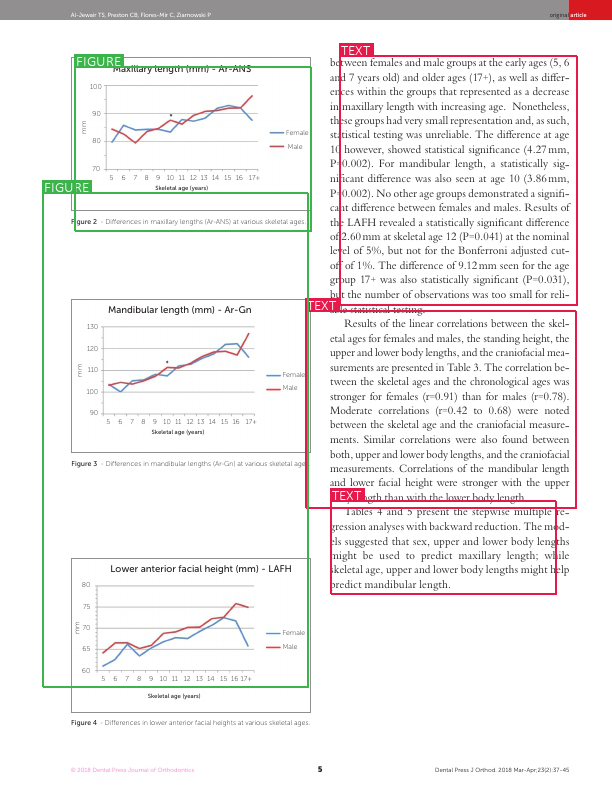

In [29]:
a

# посмотрим на еще одну картинку

In [30]:
test_dataset.img_ids[1]

354309

In [31]:
test_dataset.coco.loadImgs(354309)[0]

{'file_name': 'PMC5630080_00003.jpg',
 'width': 596,
 'id': 354309,
 'height': 842}

In [32]:
img_path = '../dataset/data/PMC5630080_00003.jpg'
original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')
a = detect(original_image, min_score=0.7, max_overlap=0.1, top_k=200)

{'text': 1, 'figure': 2, 'background': 0}
{1: 'text', 2: 'figure', 0: 'background'}


# здесь прям очень хорошо

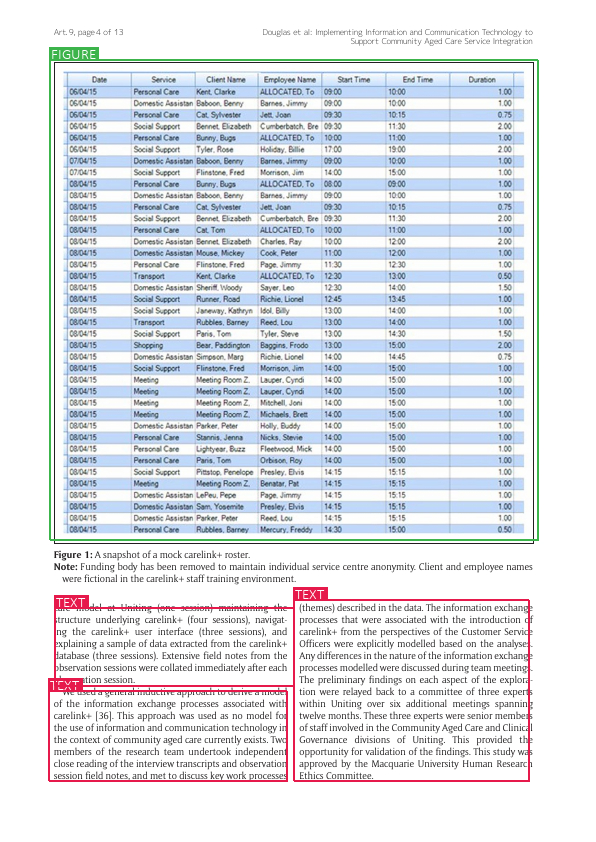

In [34]:
a

# Еще одна картинка

In [40]:
img_path = f"../dataset/data/{test_dataset.coco.loadImgs(test_dataset.img_ids[2])[0]['file_name']}"
original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')
a = detect(original_image, min_score=0.7, max_overlap=0.1, top_k=200)

{'text': 1, 'figure': 2, 'background': 0}
{1: 'text', 2: 'figure', 0: 'background'}


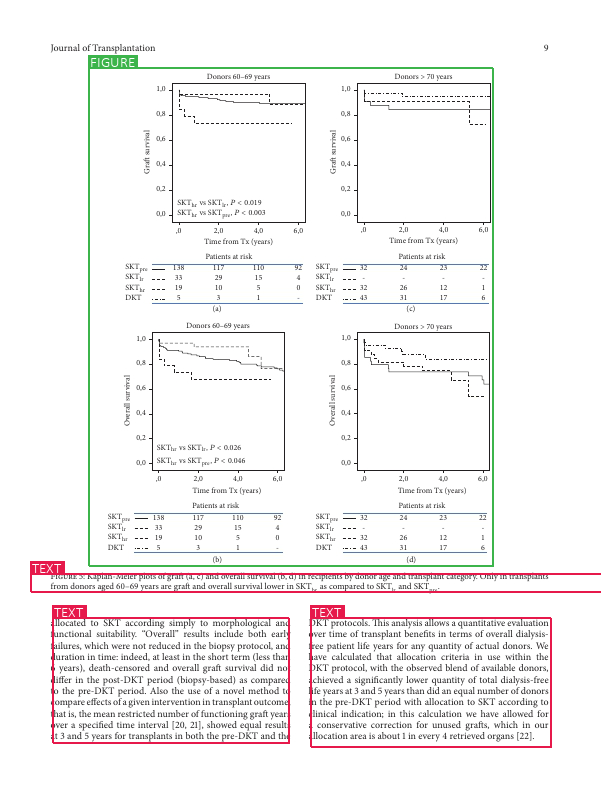

In [41]:
a

# 1000 epoch goes to nan, min_score=0.7, max_overlap=0.1, top_k=200

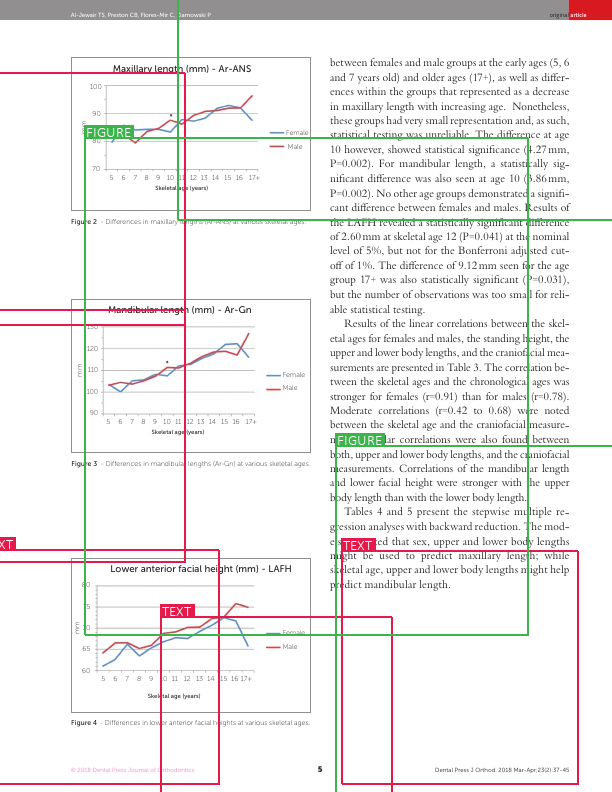

In [34]:
a

# 1 epoch result min_score=0.23, max_overlap=0.35, top_k=20

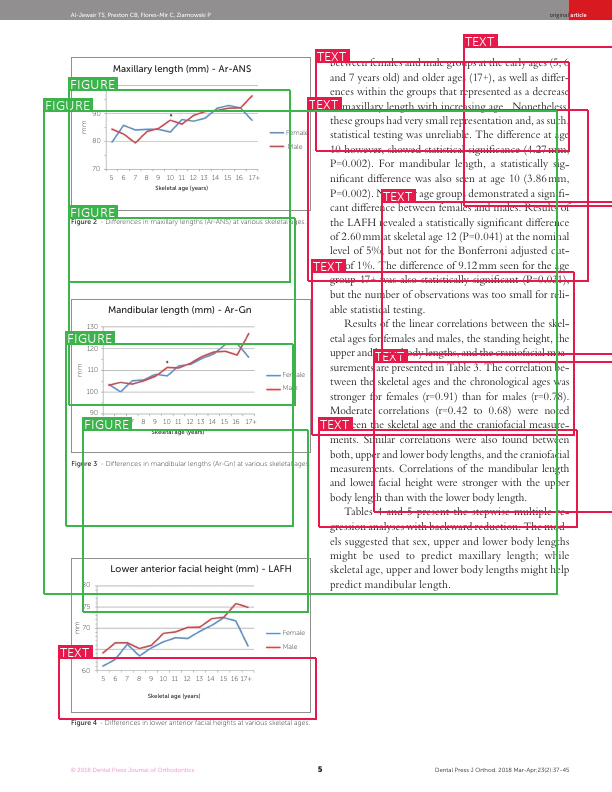

In [85]:
a